## DistilBERT Sentence Classification


In [1]:
pip install transformers

     |████████████████████████████████| 2.5 MB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 17.6 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 


In [2]:
import numpy as np
import pandas as pd

import warnings
import json


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
import transformers as ppb
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import regex as re


warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200

In [3]:
remove_per_curiam = True

# Pre-processing

In [4]:
# helpful functions
def clean_regex(df, column):
  
  df["text"] = df["text"].str.replace('\n', ' ')
  df["text"] = df["text"].replace('\s+', ' ', regex = True)
  df["text"] = df["text"].replace(r'\[','', regex=True) 
  df["text"] = df["text"].replace(r'\]','', regex=True)
  df["text"] = df["text"].replace(r'\- ','', regex=True)
  df["text"] = df["text"].replace(r'\xad','', regex=True)
  df["text"] = df["text"].replace(r'\'','', regex=True)
  df["text"] = df["text"].replace(r'\x97',',', regex=True)

  return df["text"]

In [5]:
# Keep only sentences above certain threshold of alphanumeric characters
def percent_text(text):
    char_dict = dict()
    char_dict["alpha_count"] = 0
    char_dict["total_count"] = 0

    for char in text:
        char_dict["total_count"] += 1
        if char.isalpha():
            char_dict["alpha_count"] += 1
    
    percent_letter = float(char_dict["alpha_count"]) / float(char_dict["total_count"]) * 100

    return percent_letter

In [6]:
def header_eraser(text):
    spaces = re.search(r'[ \t]{2,}', text)
    opinion = re.search(r'Opinion of', text)
    if spaces and opinion:
        # delete text between first space and opinion of + 20 char 
        result = re.sub('[ \t]{2,}.*?Opinion of[\s\S]{15}', '', text)
    else:
        result = text
    return result

## Load data

In [7]:
from google.colab import files
uploaded = files.upload()

Saving monologic_annotations.json to monologic_annotations.json


In [ ]:
#def get_clean_data(dataset_path):
#  opinion_js = json.load(open(dataset_path))
#  df = pd.DataFrame.from_dict(opinion_js)

  # Clean sentences
#  df["text"] = clean_regex(df, "text")

  # Get sentences with more letters
#  df["percent_letter"] = df["text"].apply(percent_text)
#  df = df[df["percent_letter"] > 50]

  # Remove header
#  df["text"] = df["text"].apply(header_eraser)

  # Prepare sentences for tokenization
#  all_sentences = df["text"].to_list()

#  return df, all_sentences

IndentationError: ignored

In [8]:
file_name = "monologic_annotations.json"
annotations = []
for line in open(file_name, 'r'):
    annotations.append(json.loads(line))
df = pd.DataFrame(annotations)
df["label_num"] = df["answer"].map({'accept': 1, 'reject': 0, 'ignore': 0})

In [9]:
df = df[df["answer"]!= "ignore"]

In [10]:
  # Clean sentences
  df["text"] = clean_regex(df, "text")

In [11]:
  # Get sentences with more letters
  df["percent_letter"] = df["text"].apply(percent_text)
  df = df[df["percent_letter"] > 50]

In [12]:
  # Remove header
  df["text"] = df["text"].apply(header_eraser)

In [13]:
df.sample(10)

,text,Unnamed: 0,Unnamed: 0.1,opinion_num,categority,author,case,sent_index,length,sent_location,prediction,prob_0,prob_1,_input_hash,_task_hash,label,_session_id,_view_id,answer,_merge,label_num,percent_letter
3660,We previously have recognized a significant state interest in eradicating the effects of past racial discrimination.,798366,798366,7461,majority,Justice O'Connor,Shaw v. Reno,345,369,0.934959,1,0.341105,0.658895,-1445752711,170597987,MONOLOGIC,None,classification,accept,right_only,1,86.206897
2175,"On this reasoning, the majority remands the case directly to the District Court for “full consideration of the merits of Cone’s sentencing claim.” Ante, at 27.",358065,358065,3442,dissenting,Justice Thomas,Cone v. Bell,37,203,0.182266,1,0.409769,0.590231,630989001,-488189626,MONOLOGIC,None,classification,reject,right_only,0,78.616352
3452,"Finally, the Ellerth/Faragher Court sought a frame work that would be workable and would appropriately take into account the legitimate interests of employers and employees.",1289336,1289336,12055,majority,Justice Alito,Vance v. Ball State Univ.,236,364,0.648352,1,0.351976,0.648024,-745168056,-284148824,MONOLOGIC,None,classification,reject,right_only,0,84.393064
2234,"Again, we begin with the statute.",566494,566494,5408,majority,Justice Kennedy,Bragdon v. Abbott,359,473,0.758985,1,0.418226,0.581774,-1193552635,378983760,MONOLOGIC,None,classification,accept,right_only,1,78.787879
4490,"The trustee, charged with exercising those avoiding powers, must 14 MERIT MANAGEMENT GROUP, LP v. FTI CONSULTING, INC. Opinion of the Court establish to the satisfaction of a court that the transf...",511012,511012,4865,majority,Justice Sotomayor,"Merit Management Group, LP v. FTI Consulting, Inc.",152,204,0.745098,1,0.486713,0.513287,-906049914,-1937589605,MONOLOGIC,None,classification,reject,right_only,0,81.543624
4333,"Of course, it is true that the State may in proper circumstances enact a broad regulatory scheme that incidentally restricts First Amendment rights.",242763,242763,2333,second_dissenting,Justice Brennan,California v. LaRue,134,159,0.842767,1,0.069426,0.930574,254951628,1175254072,MONOLOGIC,None,classification,reject,right_only,0,83.783784
2639,"We do not sit as a ""superlegislature"" to second-guess these policy choices.",1765217,1765217,16739,majority,Justice O'Connor,Ewing v. California,227,274,0.828467,1,0.247090,0.752910,-1825307087,1327724986,MONOLOGIC,None,classification,accept,right_only,1,80.000000
4789,"Although the Court has divided on the circumstances in which the dormant Commerce Clause allows such measures, see id., at 817 (BRENNAN, J., dissenting), surely there can be no dispute that they a...",1335300,1335300,12527,dissenting,Justice O'Connor,Metropolitan Life Ins. Co. v. Ward,171,256,0.667969,1,0.403130,0.596870,1177800110,2064217125,MONOLOGIC,None,classification,reject,right_only,0,81.894150
2178,15 The unexercised peremptory *665 argument assumes that the crucial question in the harmless-error analysis is whether a particular prospective juror is excluded from the jury due to the trial co...,874660,874660,8191,majority,Justice Blackmun,Gray v. Mississippi,145,189,0.767196,1,0.241050,0.758950,84579059,-18894057,MONOLOGIC,None,classification,reject,right_only,0,81.651376
2664,I regret very much to be compelled to say that the Court today makes a drastic and dangerous departure from a Constitution written to control and limit the government and the judges and moves towa...,1734983,1734983,16431,dissenting,Justice Black,Goldberg v. Kelly,46,69,0.666667,1,0.039707,0.960293,922081315,-318598753,MONOLOGIC,None,classification,accept,right_only,1,81.818182


In [14]:
# optional removal of per curiam
if remove_per_curiam:
  df = df[df["categority"] != "per_curiam"]

In [15]:
from collections import Counter
Counter(df["categority"])

Counter({'concurring': 511,
         'dissenting': 1527,
         'majority': 3423,
         'second_dissenting': 401})

## Training, testing, validation splits

In [ ]:
# SPLIT INTO TRAINING AND TESTING

from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(df["text"].to_list(), df["label_num"].to_list(), test_size=.3)

## Import DistilBERT

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

## Tokenize
Tokenize the text, add padding, and truncate

In [ ]:
# PASS TO TOKENIZER, ADD PADDING AND TRUNCATE
train_encodings = tokenizer(train_texts,  truncation=True, padding=True)
test_encodings = tokenizer(test_texts,  truncation=True, padding=True)

## Convert into Torch dataset

In [ ]:
# MAKE DATASET OBJECTS

class SCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = SCDataset(train_encodings, train_labels)
test_dataset = SCDataset(test_encodings, test_labels)

# Fine-tuning

## Fine-tune the model on SC data

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=50,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
)

### Load the BERT, pre-trained model
**Remember** to switch this out with BERT base

In [ ]:
device_name = 'cuda'

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased").to(device_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

Fine-tuning

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [ ]:
# Custom evaluation function 
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # custom evaluation function
)

# Training

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 4097
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 771


Step,Training Loss,Validation Loss,Accuracy
10,0.676600,0.640347,0.747153
20,0.635200,0.558531,0.747153
30,0.547400,0.496790,0.747153
40,0.425200,0.311119,0.910023
50,0.279500,0.315585,0.886105
60,0.329400,0.294596,0.907175
70,0.262700,0.334331,0.906036
80,0.282400,0.305704,0.904897
90,0.326300,0.266751,0.906036
100,0.373600,0.256749,0.911162


***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20
***** 

TrainOutput(global_step=771, training_loss=0.22961021858314595, metrics={'train_runtime': 1330.1023, 'train_samples_per_second': 9.241, 'train_steps_per_second': 0.58, 'total_flos': 2528084053739520.0, 'train_loss': 0.22961021858314595, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1756
  Batch size = 20


{'epoch': 3.0,
 'eval_accuracy': 0.9197038724373576,
 'eval_loss': 0.23605820536613464,
 'eval_runtime': 9.3859,
 'eval_samples_per_second': 187.089,
 'eval_steps_per_second': 9.376}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if remove_per_curiam:
  trainer.save_model("/content/drive/MyDrive/SCOTUS/sc_model_distilbert_clean_sentences_non_percur")
else:
  trainer.save_model("/content/drive/MyDrive/SCOTUS/sc_model_distilbert_clean_sentences")

Saving model checkpoint to /content/drive/MyDrive/SCOTUS/sc_model_distilbert_clean_sentences_non_percur
Configuration saved in /content/drive/MyDrive/SCOTUS/sc_model_distilbert_clean_sentences_non_percur/config.json
Model weights saved in /content/drive/MyDrive/SCOTUS/sc_model_distilbert_clean_sentences_non_percur/pytorch_model.bin


# Evaluation

Do the same with the test_dataset:

In [ ]:
predicted_labels = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1756
  Batch size = 20


In [ ]:
predicted_labels.label_ids.shape

(1756,)

In [ ]:
predicted_labels.label_ids[1:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 0])

In [ ]:
actual_predicted_labels = predicted_labels.predictions.argmax(-1)
len(actual_predicted_labels)

1756

In [ ]:
precision_recall_fscore_support(predicted_labels.label_ids.flatten(), actual_predicted_labels.flatten()) #, average='micro')

(array([0.93923481, 0.85815603]),
 array([0.95426829, 0.81756757]),
 array([0.94669187, 0.83737024]),
 array([1312,  444]))

In [ ]:
from sklearn.metrics import classification_report
class_report = classification_report(predicted_labels.label_ids.flatten(), actual_predicted_labels.flatten(), output_dict=True)
print(classification_report(predicted_labels.label_ids.flatten(), actual_predicted_labels.flatten()))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1312
           1       0.86      0.82      0.84       444

    accuracy                           0.92      1756
   macro avg       0.90      0.89      0.89      1756
weighted avg       0.92      0.92      0.92      1756



In [ ]:
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv("/content/drive/MyDrive/SCOTUS/class_report_3", index= True)

## Confusion Matrix

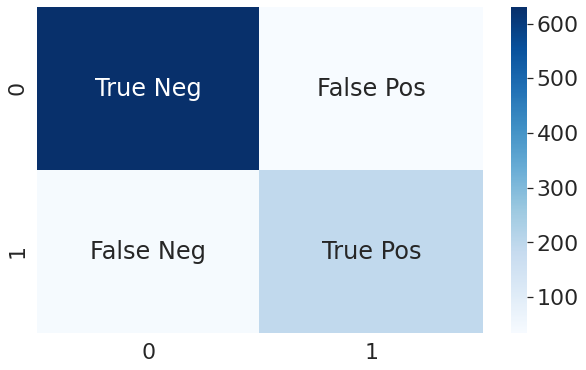

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
# Confusion Matrix
confusion_m = metrics.confusion_matrix(predicted_labels.label_ids.flatten(), actual_predicted_labels.flatten())
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,6))
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ax = ax, data = confusion_m, annot=labels, fmt="", cmap="Blues");

# Predictions

In [ ]:
val_results = list(zip(predicted_labels.label_ids, actual_predicted_labels, val_texts))
val_results = pd.DataFrame(val_results, columns=['Predicted', 'Actual','Text'])

In [ ]:
val_results.head(10)

,Predicted,Actual,Text
0,0,0,"This case involves a “matter of sovereign interest”—the equita ble apportionment of water—and the States therefore “properly represent” the shared interests in water of “all” their citizens, inclu..."
1,0,0,"Any other construction would be illogical and disrespectful of the plain congressional purpose in amending § 7, because it would create a large loophole in a statute designed to close a loophole."
2,0,0,"at 89, the Court's judgment did not rest on that point, and in no way purported to hold that statements with such an attribute were presumptively admissible."
3,0,0,"The floor debates and the House Report on the proposed legislation clearly reveal, as at least one commentator has noted, that ""Congress fully understood the narrow scope given to the commerce cla..."
4,0,0,"The Court held in Speiser that *178 the defect in the California procedure was not only that the applicant bore the final burden of persuasion but that ""when the constitutional right to speak is s..."
5,0,0,"High fundraising costs, without more, do not establish fraud."
6,1,1,B We move on to respondent's collateral-estoppel argument.
7,0,0,"Article IV provides that the “United States shall guarantee to every State in this Union a Republican Form of Government, and shall protect each of them against Invasion; and on Application of the..."
8,0,0,Mount Ephraim is a small community on the periphery of two major urban centers where this kind of entertainment may be found acceptable.
9,0,0,"*241 By its terms, the Commission's averment of ""reason to believe"" that Socal was violating the Act is not a definitive statement of position."


In [ ]:
correct = val_results[val_results["Predicted"]==val_results["Actual"]]

In [ ]:
# True Positives
correct[correct["Actual"] == 1].head(10)

,Predicted,Actual,Text
6,1,1,B We move on to respondent's collateral-estoppel argument.
18,1,1,"I would base the reversal on Boyd v. United States, 116 U.S. 616, or, in the alternative, I would overrule the five-to-four decision of Brown v. Walker, 161 U.S. 591, and adopt the view of the min..."
20,1,1,"Rather, we concluded that Congress enacted the FDCA “to bolster consumer protection against harmful products;” that Congress provided no “federal remedy for consumers harmed by unsafe or ineffecti..."
22,1,1,When the courts are flooded with litigation under that most unmanageable of standards (Branti) brought by that most persistent and tenacious of suitors (the disappointed officeseeker) we may be mo...
23,1,1,12 *597 Our former decisions interpretative of the Communications Act furnish a basis for examining this question.
25,1,1,We do not think it is necessary to relate the details of the proposal.
32,1,1,"In sum, I would simply hold that there is no constitu tional right to “informational privacy.” Besides being consistent with constitutional text and tradition, this view has the attractive benefit..."
37,1,1,"I also agree that Florida may not base its employment decisions, as to state teachers or any other hiring category, on an applicant's willingness vel non to affirm ""that I do not believe in the ov..."
49,1,1,"As we have indicated above, however, the airline ticket transaction in this case is not a ""deduction from"" Matise's wages, but rather is itself a partial payment of wages."
56,1,1,"THE CHIEF JUSTICE and I further asserted that the enforcement of this rule should be committed to the state and federal courts whose judgments made pursuant to the Roth rule we would accept, limit..."


In [ ]:
# True Negatives
correct[correct["Actual"] == 0].head(10)

,Predicted,Actual,Text
0,0,0,"This case involves a “matter of sovereign interest”—the equita ble apportionment of water—and the States therefore “properly represent” the shared interests in water of “all” their citizens, inclu..."
1,0,0,"Any other construction would be illogical and disrespectful of the plain congressional purpose in amending § 7, because it would create a large loophole in a statute designed to close a loophole."
2,0,0,"at 89, the Court's judgment did not rest on that point, and in no way purported to hold that statements with such an attribute were presumptively admissible."
3,0,0,"The floor debates and the House Report on the proposed legislation clearly reveal, as at least one commentator has noted, that ""Congress fully understood the narrow scope given to the commerce cla..."
4,0,0,"The Court held in Speiser that *178 the defect in the California procedure was not only that the applicant bore the final burden of persuasion but that ""when the constitutional right to speak is s..."
5,0,0,"High fundraising costs, without more, do not establish fraud."
7,0,0,"Article IV provides that the “United States shall guarantee to every State in this Union a Republican Form of Government, and shall protect each of them against Invasion; and on Application of the..."
8,0,0,Mount Ephraim is a small community on the periphery of two major urban centers where this kind of entertainment may be found acceptable.
9,0,0,"*241 By its terms, the Commission's averment of ""reason to believe"" that Socal was violating the Act is not a definitive statement of position."
10,0,0,"In that circumstance, —————— news to the Taylor, Shepard, and Johnson Courts: All those decisions rested on the explicit premise that the laws “contained statutory phrases that cover several diffe..."


In [ ]:
errors = val_results[val_results["Predicted"]!=val_results["Actual"]]

In [ ]:
# False Positives
errors[errors["Predicted"] == 1].head(10)

,Predicted,Actual,Text
50,1,0,"The Court nonetheless concludes that Myers' questions about the effect of petitioner's personnel policies on employee morale and overall work performance are not ""of public import in evaluating th..."
60,1,0,"As the Court makes clear, the Eighth Amendment prohibits the unnecessary and wanton infliction of ""pain,"" rather than ""injury."""
75,1,0,It could not be more clear that Farah's policy of excluding aliens is de facto a policy of preferring those who were born in this country.
113,1,0,"Under the ""fair warning"" rationale the Court adopts today, there was, and is, no such constitutional barrier."
118,1,0,"2 The Court justifies affirming the release of Pearce in this language: ""In order to assure the absence of such a motivation, we have concluded that whenever a judge imposes a more severe sentence..."
132,1,0,"Respondent has shown us no ""obvious and appreciable"" injury to the borrowing power of the United States Government as a result of Nebraska's taxation of the repo income earned by the Trusts."
154,1,0,"35 Congress thereby indicated its firm intention to leave monitoring of the equitable injunctive process to the courts of appeals in the first instance, and to reserve mandatory direct Supreme Cou..."
183,1,0,"In those circumstances, as the majority suggests, the agency may be able to support an expert’s testimony in ways other than by providing underlying data, such as by offering a fulsome description..."
204,1,0,"To determine whether exigent 12 MITCHELL v. WISCONSIN SOTOMAYOR, J., dissenting circumstances justify a warrantless search, the Court “looks to the totality of ..."
221,1,0,"Even though the State's law is not conclusive with regard to the attitudes of the local community on obscenity, nothing we have said is designed to imply that the Iowa statute should not have been..."


In [ ]:
# False Negatives
errors[errors["Predicted"] == 0].head(10)

,Predicted,Actual,Text
19,0,1,And the police power of a State under our constitutional system is adequate for the protection of the civil rights of its citizens against discrimination by reason of race or color.
45,0,1,"Standing in the way is an obstacle, a technicality of little interest to anyone but the people of We the People, who created it as a barrier against judges’ intrusion into their lives."
46,0,1,"Yet only one of them—our Court—is capable, under the Con- stitution, of exercising the Government’s judicial power."
77,0,1,This Court has specifically upheld this rulemaking authority in the context of regulations based on the Commission's policy of promoting diversification of ownership.
137,0,1,"To conclude, as the Court does, that the transferee court is inexorably designated by the inherent force of the words ""where it might have been brought"" is to state a conclusion that conceals the ..."
158,0,1,This Court was of course aware of the practical pressures of the New York statute as a device to collect debts discharged in bankruptcy; the argument was pressed upon it in the dissent.
186,0,1,"Quite apart from any question of governmental estoppel respecting assertion of the statute of limitations, a contention that is sought to be predicated on the foregoing train of events and circums..."
222,0,1,"Although it has been argued that foreseeability of causing injury in another State should be sufficient to establish such contacts there when policy considerations so require,16 the Court has cons..."
249,0,1,"The Court concluded: ""In light of history, experience, and the present limitations of human knowledge, we find it quite impossible to say that committing to the untrammeled discretion of the jury ..."
253,0,1,"Under this view, the Court's precedents on prisoner ""rights"" bear some reexamination."


In [ ]:
errors.shape

(73, 3)

In [ ]:
errors.head(20)

,Predicted,Actual,Text
19,0,1,And the police power of a State under our constitutional system is adequate for the protection of the civil rights of its citizens against discrimination by reason of race or color.
45,0,1,"Standing in the way is an obstacle, a technicality of little interest to anyone but the people of We the People, who created it as a barrier against judges’ intrusion into their lives."
46,0,1,"Yet only one of them—our Court—is capable, under the Con- stitution, of exercising the Government’s judicial power."
50,1,0,"The Court nonetheless concludes that Myers' questions about the effect of petitioner's personnel policies on employee morale and overall work performance are not ""of public import in evaluating th..."
60,1,0,"As the Court makes clear, the Eighth Amendment prohibits the unnecessary and wanton infliction of ""pain,"" rather than ""injury."""
75,1,0,It could not be more clear that Farah's policy of excluding aliens is de facto a policy of preferring those who were born in this country.
77,0,1,This Court has specifically upheld this rulemaking authority in the context of regulations based on the Commission's policy of promoting diversification of ownership.
113,1,0,"Under the ""fair warning"" rationale the Court adopts today, there was, and is, no such constitutional barrier."
118,1,0,"2 The Court justifies affirming the release of Pearce in this language: ""In order to assure the absence of such a motivation, we have concluded that whenever a judge imposes a more severe sentence..."
132,1,0,"Respondent has shown us no ""obvious and appreciable"" injury to the borrowing power of the United States Government as a result of Nebraska's taxation of the repo income earned by the Trusts."


In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score

# Baseline Accuracy
This is the baseline accuracy of the logistic regression model.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')

stop_words=frozenset(['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'it', 'for', 'not', 'on', 'with', 'as', 'do', 'at', 'this', 'but', 'by', 'from'])

# Set up the vectorizer

vectorizer = TfidfVectorizer(
    encoding='utf-8',
    min_df=2, 
    stop_words=stop_words,
    binary=False,
    tokenizer=nltk.word_tokenize,
    norm='l2',
    use_idf=False 
)

X = vectorizer.fit_transform(df.text)
y = df.label_num

# Classification
lr = LogisticRegression()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(X.shape)
print(y.shape)

(1998, 3751)
(1998,)


In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
scores = cross_validate(lr, X, y, cv=10, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
print(np.mean(scores.get("test_f1")))
print(np.mean(scores.get("test_accuracy")))

0.005128205128205127
0.8093090452261308
